# A tour of navground

In this tour you meet the basic components of the navigation playground 
and see them at play.

At the core of the playground there is a library of navigation behaviors for dynamic obstacle avoidance. 

Let's import the library and instantiate one of the behavior ([DummyBehavior](../reference/core/python/behaviors/dummy.html#navground.core.behaviors.DummyBehavior)).

## Behaviors

In [1]:
from navground import core

behavior = core.behaviors.DummyBehavior()

Behaviors holds the **2D state of an agent** of circular shape. We set

- the [pose](../reference/core/python/common.html#navground.core.Pose2)
of the agent at the origin of the world-fixed coordinate frame

In [2]:
behavior.pose = core.Pose2(position=(0, 0), orientation=0)

- the [twist](../reference/core/python/common.html#navground.core.Twist2) of the agent to zero

In [3]:
behavior.twist = core.Twist2(velocity=(0, 0), angular_speed=0)

- and the radius of the agent

In [4]:
behavior.radius = 1.0

A behavior needs also  [target](../reference/core/python/target.html#navground.core.Target): let's go to ``(10, 0)``, stopping when near enough.

In [5]:
behavior.target = core.Target.Point((10, 0), tolerance=0.5)

Once we have set a target, we can ask for a [control command](../reference/core/python/behaviors/behavior.html#navground.core.Behavior.compute_cmd) (a twist) to advance towards the target in the next control step.

In [6]:
behavior.compute_cmd(time_step=0.1)

Missing kinematics!


Twist2((0.000000, 0.000000), 0.000000, frame=Frame.absolute)

Oops ... the behavior is complaining that it does not have know which kinematics the agent is using.
Therefore it play safe and make it stay in place. We also see that `Twist2` have an additional fields `Twist2(..., frame)` that tells the coordinate frame of the command. 


A [kinematics](../reference/core/python/kinematics.html#navground.core.Kinematics) knows the maximal speed and more generally which commands are feasible by the agent.
Let's pick an omnidirectional kinematics that has no restrictions but maximal horizontal and angular speeds.

In [7]:
kinematics = core.kinematics.OmnidirectionalKinematics(max_speed=2.0, max_angular_speed=1.0)
behavior.kinematics = kinematics

and ask again for a control command

In [8]:
cmd = behavior.compute_cmd(time_step=0.1)
cmd

Twist2((2.000000, 0.000000), 0.000000, frame=Frame.absolute)

As expected, the behavior wants to advance full speed towards the target point.
How to actuate the commands depends on the actual agents we are controlling and may requires interacting with the agent's runtime.

Here, we keep it simple and simulate the movements by ourself without any error. 
We apply the command for a time step to directly update the behavior state

In [9]:
behavior.actuate(cmd, time_step=0.1)

To get the same result, we could have manually integrated the pose and set the twist

In [10]:
behavior.pose = behavior.pose.integrate(cmd, time_step=0.1)
behavior.twist = cmd

Note that behaviors are already instatiated at zero:
we could have setup the behavior with these two lines

In [11]:
behavior = core.behaviors.DummyBehavior(kinematics=kinematics, radius=0.5)
behavior.target = core.Target.Point((10, 0), tolerance=0.5)

## Registers

What if our agent has wheels? There are other kinematics implemented in the core library. Let's list their names:

In [12]:
core.Kinematics.types

['2WDiff', '4WOmni', 'Ahead', 'Omni']

`"Omni"` is the one we already used. Let's pick "2WDiff", which corresponds to a robot with two different drive wheels, one per side of an axis.

In [13]:
kinematics = core.Kinematics.make_type("2WDiff")
kinematics.max_speed = 1.0

Registered components declare properties that we can use to configure them

In [14]:
for name, p in kinematics.properties.items():
    print(f'Property {name}: {p.description} (type={p.type_name})')

Property wheel_axis: Wheel Axis (type=float)


In [15]:
kinematics.set("wheel_axis", 2.0)   # here equal to the agent diameter.

Instantiating from the kinematics from a register and configuring through its properties, is equivalent to an explicit instantiation like

In [16]:
kinematics = core.kinematics.TwoWheelsDifferentialDriveKinematics(max_speed=1.0, axis=2.0)

Let's get a command that respects this kinematics

In [17]:
behavior.kinematics = kinematics 
cmd = behavior.compute_cmd(time_step=0.1)
cmd

Twist2((1.000000, 0.000000), 0.000000, frame=Frame.relative)

which we can convert to left and right wheel speeds

In [18]:
behavior.kinematics.wheel_speeds(cmd)

[1.0, 1.0]

## Trajectory

Applying the control step iteratively, we make the agent reach the target point.
We also store its positionsand to plot them.

In [19]:
import numpy as np

positions = []

time_step = 0.1

while not behavior.check_if_target_satisfied():
    positions.append(behavior.position)
    cmd = behavior.compute_cmd(time_step=time_step)
    behavior.actuate(cmd, time_step=time_step)
    
positions = np.asarray(positions)

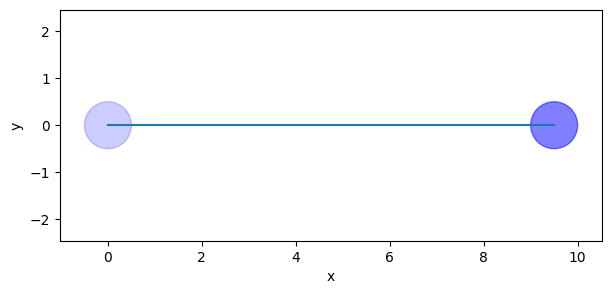

In [20]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=((7, 3)))
ax.add_patch(plt.Circle(positions[0], behavior.radius, color='blue', alpha=0.2))
ax.add_patch(plt.Circle(positions[-1], behavior.radius, color='blue', alpha=0.5))
# ax.add_patch(plt.Circle(behavior.target.position, behavior.target.position_tolerance, color='red', alpha=0.6, fill=False))
ax.plot(positions[:, 0], positions[:, 1], '-')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

We got the trajectory we expected, altough not a particularly interesting one.

## Environment state

The job of the behavior is to navigate the agent through obstacles. So let's add a round obstacle in the middle of the agent's path.

In [21]:
disc = core.Disc(position=(5.0, 0.1), radius=1)

How do we tell the behavior to avoid the obstacle?
For this, each behavior keep an enviroment state ... unfortunately our current behavior, 
as we may expect from a behavior called *Dummy*) does have one: 

In [22]:
behavior.environment_state is None

True

So, let's switch to a smarter behavior. Like for kinematics, behaviors are registered by name

In [23]:
core.Behavior.types

['Dummy', 'HL', 'HRVO', 'ORCA', 'PyDummy', 'SocialForce']

We pick "ORCA" and setup it with the same kinematics, state and target

In [24]:
behavior = core.Behavior.make_type('ORCA')
behavior.kinematics = kinematics
behavior.pose = core.Pose2((0, 0), 0)
behavior.twist = core.Twist2((0, 0), 0)
behavior.radius = 1.0
behavior.target = core.Target.Point((10, 0), tolerance=0.5)

This behavior has a more usefull enviroment state which can represent static obstacles:

In [25]:
behavior.environment_state.static_obstacles = [disc]

Let's that the behavior is considering the obstacle 

In [26]:
behavior.compute_cmd(0.1)

Twist2((0.150420, 0.000000), -0.224969, frame=Frame.relative)

Indeed ... the behavior is telling us to steer clockwise. Let's plot the trajectory

In [27]:
positions = []

while not behavior.target.satisfied(behavior.pose):
    positions.append(behavior.position)
    cmd = behavior.compute_cmd(0.1)
    behavior.actuate(cmd, 0.1)
    
positions = np.asarray(positions)

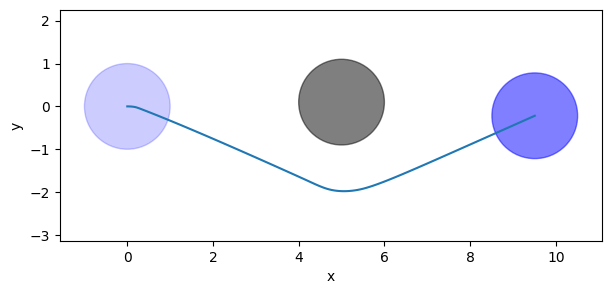

In [28]:
fig, ax = plt.subplots(figsize=((7, 3)))
ax.add_patch(plt.Circle(disc.position, disc.radius, color='k', alpha=0.5))
ax.add_patch(plt.Circle(positions[0], behavior.radius, color='blue', alpha=0.2))
ax.add_patch(plt.Circle(positions[-1], behavior.radius, color='blue', alpha=0.5))
ax.plot(positions[:, 0], positions[:, 1], '-')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

A more interesting trajectory indeed.

## Controllers

Controllers monitor a behavior to report when it as reached a target.

Let's try again the same scenario, but now using a controller. 

In [29]:
behavior.pose = core.Pose2((0, 0), 0)
behavior.twist = core.Twist2((0, 0), 0)
controller = core.Controller(behavior)

time_step = 0.1

def actuate(cmd):
    behavior.actuate(cmd, time_step=time_step)

controller.set_cmd_cb(actuate)

Targets are now set through the controller, which return an action.

In [30]:
action = controller.go_to_pose(core.Pose2((10, 0), 3.14), 0.1, 0.1)

which we can optionally use to setup callbacks

In [31]:
action.done_cb = lambda action_state: print(f"Action has finished with state {action_state}")

Commands are also queries through the controller, which monitor the action state

In [32]:
positions = []

while not controller.idle:
    controller.update(time_step=time_step)
    positions.append(behavior.position)
    
positions = np.asarray(positions)

Action has finished with state State.success


## More agents

Within the playground, we can play with more than a single agent.
Let's add a second agent with the same shape, kinematics, and type of behavior.

In [33]:
behavior_1 = core.Behavior.make_type("ORCA")
behavior_1.radius = 1.0
behavior_1.kinematics = kinematics
behavior_2 = core.Behavior.make_type("ORCA")
behavior_2.radius = 1.0
behavior_2.kinematics = kinematics
behaviors = [behavior_1, behavior_2]

We want to make them cross. Let them start from opposing poses

In [34]:
behavior_1.pose = core.Pose2((0, 0), 0)
behavior_2.pose = core.Pose2((10, 0), np.pi)

and make them exchange positions 

In [35]:
behavior_1.target = core.Target.Point(behavior_2.position, 0.1)
behavior_2.target = core.Target.Point(behavior_1.position, 0.1)

We need to tell the behavior that there is another agent in their vicinity.
Neighbors are also of circular shape and their state has a position, a radius, and a velocity.
Generally, enviroment state originate from perception algorithm, which may be noisy and have partial visibility.
Here we keep it simple and make the agents avoid all other agents, adding a neighbor where they are.

In [36]:
for behavior in behaviors:
    behavior.environment_state.neighbors = [
        core.Neighbor(position=b.position, radius=b.radius, velocity=b.velocity)
        for b in behaviors if b is not behavior
    ]

Let's try again to compute the trajectories. Contrary to static obstacles, neighbors ... do move. 
So we need to update them before asking for a new control commands

In [37]:
positions = []
time_step = 0.1

while not all(b.target.satisfied(b.pose) for b in behaviors):
    positions.append([b.position for b in behaviors])
    cmds = []
    for behavior in behaviors:
        behavior.environment_state.neighbors = [
            core.Neighbor(position=b.position, radius=b.radius, velocity=b.velocity)
            for b in behaviors if b != behavior
        ]
        cmds.append(behavior.compute_cmd(time_step=time_step))
    for behavior, cmd in zip(behaviors, cmds):
        behavior.actuate(cmd, time_step=time_step)
    
positions = np.asarray(positions)

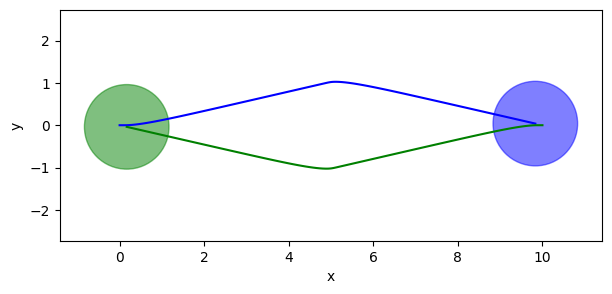

In [38]:
fig, ax = plt.subplots(figsize=((7, 3)))
for i, (behavior, color) in enumerate(zip(behaviors, 'bg')):
    ax.add_patch(plt.Circle(positions[-1, i], behavior.radius, color=color, alpha=0.5))
    ax.plot(positions[:, i, 0], positions[:, i, 1], '-', color=color)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

This concludes the tour of the core of navground. 
It you want to go ahead and integrate some of its components in your system, 
you can skip the rest of the tour.

## Simulation

We have seen how to manually write a run loop to simulate a trajectory.

The playground simplifies this process using `Agent`, `StateEstimation` and `Task`,
which generalize the functionalities we have been implementing.

An agent holds a behavior and a kinematics

In [39]:
from navground import sim
agent = sim.Agent()
agent.behavior = core.Behavior.make_type('ORCA')
agent.kinematics = core.kinematics.TwoWheelsDifferentialDriveKinematics(max_speed=1.0, axis=2.0)
agent.pose = core.Pose2((0, 0), 0)
agent.twist = core.Twist2((0, 0), 0)
agent.radius = 1.0

A task generates targets. Let's pick ``WaypointsTask`` to ask the agent to pendle between a point and it's original position.

In [40]:
agent.task = sim.tasks.WaypointsTask(waypoints=[(10, 0), (0, 0)], loop=True, tolerance=0.1)

A state estimation updates the ... agent's behavior environment state 

In [41]:
agent.state_estimation = sim.state_estimations.BoundedStateEstimation(range_of_view=5.0)

Let's us now add the agent to a world, together with a static obstacle

In [42]:
world = sim.World()
world.add_obstacle(disc)
world.add_agent(agent)

and that's all we have to do to setup our simulation. Let us run it for a while.

In [43]:
world.run(steps=10, time_step=0.1)

Nice ... but we would like to plot the trajectory again.

In [44]:
positions = []
for i in range(200):
    world.run(steps=1, time_step=0.1)
    positions.append([a.position for a in world.agents])
    
positions = np.asarray(positions)

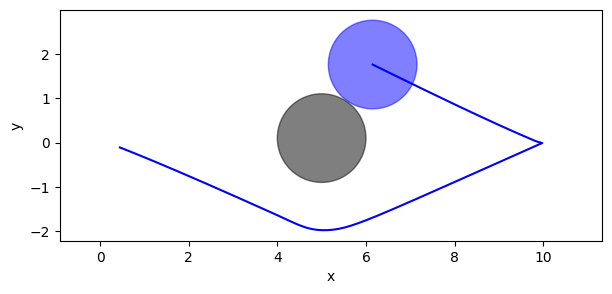

In [45]:
fig, ax = plt.subplots(figsize=((7, 3)))
ax.add_patch(plt.Circle(disc.position, disc.radius, color='k', alpha=0.5))
for i in range(positions.shape[1]):
    ax.plot(positions[:, i, 0], positions[:, i, 1], 'b-')
    ax.add_patch(plt.Circle(positions[-1, i], behavior.radius, color='b', alpha=0.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

## Experiment

Instead of manually intejecting in the run loop, we can configure an ``Experiment`` to do it for us.

Let's start by defining a scenario, which is a object that initializes worlds, with the same commands as before.

In [46]:
class MyScenario(sim.Scenario):

    def __init__(self):
        super().__init__()
    
    def init_world(self, world: sim.World) -> None:
        super().init_world(world)
        agent = sim.Agent()
        agent.behavior = core.Behavior.make_type('ORCA')
        agent.kinematics = core.kinematics.TwoWheelsDifferentialDriveKinematics(max_speed=1.0, axis=2.0)
        agent.pose = core.Pose2((0, 0), 0)
        agent.twist = core.Twist2((0, 0), 0)
        agent.radius = 1.0
        agent.task = sim.tasks.WaypointsTask(waypoints=[(10, 0), (0, 0)], loop=True, tolerance=0.1)
        agent.state_estimation = sim.state_estimations.BoundedStateEstimation(range_of_view=5.0)
        world.add_obstacle(core.Disc(position=(5.0, 0.1), radius=1))
        world.add_agent(agent)

and then an experiment that will use it. 

In [47]:
experiment = sim.Experiment()
experiment.scenario = MyScenario()
experiment.time_step = 0.1
experiment.steps= 300
experiment.runs = 1

We are interested to record agent poses

In [48]:
experiment.trace.record_pose = True

so let run the experiment

In [49]:
experiment.run()

In [50]:
trajectories = np.asarray(experiment.trace.poses)
trajectories.shape

(300, 1, 3)

Optionally, you can save the data to an h5df file automatically at the end of a run.

In [51]:
import h5py
import pathlib

experiment = sim.Experiment()
experiment.scenario = MyScenario()
experiment.time_step = 0.1
experiment.steps= 300
experiment.trace.record_pose = True
experiment.runs = 1
experiment.save_directory = pathlib.Path('.')

# experiment.run()
# 
# if experiment.path:
    # data = h5py.File(pathlib.Path(experiment.path) / 'data.h5')
    # data    

## YAML

Most of what we configured in Python during this tutorial, can be configured from YAML.

Let's try configuring the last experiment using YAML. We add our lonely agent in one of  `experiment/groups`

In [52]:
yaml = """
time_step: 0.1
steps: 300
runs: 1
record_pose: true
runs: 1
scenario:
    obstacles:
        - position: [5, 0.1]
          radius: 1.0
    groups:
        - number: 1
          type: thymio
          behavior:
            type: ORCA
          kinematics:
            type: 2WDiff
            wheel_axis: 2
            max_speed: 1
          task:
            type: Waypoints
            loop: true
            tolerance: 0.1
            waypoints: [[10, 0], [0, 0]]
          state_estimation:
            type: Bounded
            range_of_view: 5
          position: [0, 0]
          orientation: 0
          radius: 1.0
          control_period: 0.1        
"""

In [53]:
experiment = sim.load_experiment(yaml)
experiment.run()

YAML is also usefull to display a readable representation. Let's try to look at world at the end of the experiment:



In [54]:
print(sim.dump(experiment.world))

obstacles:
  - position:
      - 5
      - 0.100000001
    radius: 1
    uid: 5
walls:
  []
agents:
  - behavior:
      type: ORCA
      effective_center: false
      time_horizon: 10
      optimal_speed: 1
      optimal_angular_speed: 1
      rotation_tau: 0.5
      safety_margin: 0
      horizon: 5
      radius: 1
      heading: velocity
      kinematics:
        type: 2WDiff
        wheel_axis: 2
        max_speed: 1
        max_angular_speed: 1
      social_margin:
        modulation:
          type: constant
        default: 0
    kinematics:
      type: 2WDiff
      wheel_axis: 2
      max_speed: 1
      max_angular_speed: 1
    task:
      type: Waypoints
      loop: true
      tolerance: 0.100000001
      waypoints:
        -
          - 10
          - 0
        -
          - 0
          - 0
    state_estimation:
      type: Bounded
      range_of_view: 5
    position:
      - 0.0844370797
      - 0.0417474806
    orientation: 4.70049715
    velocity:
      - 0
      - -0
    a

## Real-time simulation

The last step is possibly the most rewarding. Let's try to visualize a simulation while it runs directly in the notebook. To do it, you need to install the Python websockets packages
```
pip install websockets
```

In [55]:
from navground.sim.ui.web_ui import WebUI
from navground.sim.ui.to_html import notebook_view
from navground.sim.real_time import RealTimeSimulation

web_ui = WebUI(host='127.0.0.1', max_rate=-1)
await web_ui.prepare()


True

In [56]:
notebook_view(width=500)

In [57]:
# we run 5x faster than real-time
world = experiment.world
rt_sim = RealTimeSimulation(world=world, time_step=0.1, factor=5, web_ui=web_ui, 
                            bounds=((-1, -3), (11, 3)))
await rt_sim.init()

In [58]:
until_time = world.time + 60
await rt_sim.run(until=lambda : world.time > until_time)